In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py

import tensorflow as tf
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from time import time
from icecream import ic

from msfm.utils import tfrecords, files, parameters
from msfm.fiducial_pipeline import FiducialPipeline
from msfm.utils.input_output import read_yaml

24-02-09 02:33:16   imports.py INF   Setting up healpy to run on 256 CPUs 
24-02-09 02:33:17   imports.py INF   Setting up healpy to run on 256 CPUs 


# v4 of the pipeline (multiple poisson noise realizations)

In [3]:
# tfr_pattern = "/pscratch/sd/a/athomsen/DESY3/v4/extra_large_scales/tfrecords/fiducial/DESy3_fiducial_000.tfrecord"
# tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v4/large_scales/tfrecords/fiducial/DESy3_fiducial_000.tfrecord"

# tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v5/debug/tfrecords/fiducial/DESy3linear_fiducial_000.tfrecord"
# conf = "/cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model/configs/config.yaml"
# params = ["Om", "s8", "Aia", "n_Aia", "bg", "n_bg"]
# filename_suffix = "_linear"

# tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v5/debug/tfrecords/fiducial/DESy3quadratic_fiducial_000.tfrecord"
# conf="/cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model/configs/config_quadratic_bias.yaml"
# params = ["Om", "s8", "Aia", "n_Aia", "bg", "n_bg", "bg2", "n_bg2"]
# filename_suffix = "_quadratic"




# tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v5/linear_bias/tfrecords/fiducial/DESy3_fiducial_000.tfrecord"
# tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v5/linear_bias/debug/DESy3_fiducial_000.tfrecord"
# tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v5/debug/DESy3linear_fiducial_000.tfrecord"
# conf = "/cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model/configs/v5/linear_bias.yaml"
# params = ["Om", "s8", "Aia", "n_Aia", "bg", "n_bg"]
# filename_suffix = "_linear_v2"

# tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v5/quadratic_bias/tfrecords/fiducial/DESy3_fiducial_000.tfrecord"
# tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v5/quadratic_bias/debug/DESy3_fiducial_000.tfrecord"
# conf = "/cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model/configs/v5/quadratic_bias.yaml"
# params = ["Om", "s8", "Aia", "n_Aia", "bg", "n_bg", "bg2", "n_bg2"]
# filename_suffix = "_quadratic"

# tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v5/debug/DESy3bias_2_fiducial_000.tfrecord"
# tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v5/debug/DESy3bias_1_fiducial_000.tfrecord"
# conf = "/cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model/configs/v5/quadratic_bias.yaml"
# params = ["Om", "s8", "Aia", "n_Aia", "bg", "n_bg", "bg2", "n_bg2"]
# filename_suffix = "_quadratic_v1"

# tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v5/stochasticity/tfrecords/fiducial/DESy3_fiducial_000.tfrecord"
# # tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v5/debug/DESy3stoch_fiducial_000.tfrecord"
# conf = "/cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model/configs/v5/stochasticity.yaml"
# params = ["Om", "s8", "Aia", "n_Aia", "bg", "n_bg"]
# filename_suffix = "_stochasticity"

# tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v5/debug/DESy3_fiducial_000.tfrecord"
# conf = "/cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model/configs/v5/linear_bias.yaml"
# params = ["Om", "s8", "Ob", "H0", "ns", "w0", "Aia", "n_Aia", "bg", "n_bg"]
# filename_suffix = ""

# tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v5/debug/DESy3_quadratic_fiducial_000.tfrecord"
# conf = "/cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model/configs/v5/quadratic_bias.yaml"
# params = ["Om", "s8", "Ob", "H0", "ns", "w0", "Aia", "n_Aia", "bg", "n_bg", "bg2", "n_bg2"]
# filename_suffix = "_quadratic"

# tfr_pattern = "/pscratch/sd/a/athomsen/DESY3/v5/linear_bias/tfrecords/fiducial/DESy3_fiducial_000.tfrecord"
# tfr_pattern = "/pscratch/sd/a/athomsen/DESY3/v6/linear_bias/tfrecords/fiducial/DESy3_fiducial_0000.tfrecord"

# conf = "//global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v6/linear_bias.yaml"
# params = ["Om", "s8", "Ob", "H0", "ns", "w0", "Aia", "n_Aia", "bg", "n_bg"]
# filename_suffix = "v6"


# v6

In [4]:
tfr_pattern = "/pscratch/sd/a/athomsen/DESY3/v7/linear_bias/tfrecords/fiducial/DESy3_fiducial_*.tfrecord"

conf = "//global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v6/linear_bias.yaml"
# params = ["Om", "s8", "Ob", "H0", "ns", "w0", "Aia", "n_Aia", "bg", "n_bg"]
params = []
filename_suffix = "v6"

In [5]:
noise_schedule_steps = 30

noise_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=0.0, decay_steps=noise_schedule_steps, end_learning_rate=1.0, power=1.0
)
noise_scale = tf.Variable(noise_scheduler(0), trainable=False, dtype=tf.float32)
noise_kwargs = {"shape_noise_scale": noise_scale, "poisson_noise_scale": noise_scale}

In [6]:
pipe = FiducialPipeline(
    conf=conf,
    params=params,
    with_lensing=True,
    with_clustering=True,
    with_padding=True,
    apply_norm=False,
    **noise_kwargs,
)

n_side = 512
n_pix = hp.nside2npix(n_side)

params = pipe.params
n_params = len(params)
n_maps = 2 * len(params) + 1 
n_noise = 3
data_vec_pix = pipe.data_vec_pix
n_z = pipe.n_z_metacal + pipe.n_z_maglim
n_z_metacal = pipe.n_z_metacal

# gnomview arguments
i_fid = 0

# in degrees
x_deg = 10
y_deg = x_deg

# in pixels
x_pix = 600
y_pix = x_pix

# in arcminute / pixel
reso = x_deg / x_pix * 60

24-02-09 02:33:20     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5 
24-02-09 02:33:20     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5 


In [9]:
dset = pipe.get_dset(
    tfr_pattern=tfr_pattern,
    local_batch_size=1,
    # n_noise=n_noise,
    n_noise=1,
    n_readers=1,
    examples_shuffle_buffer=None,
    n_prefetch=0,
    is_eval=True,
)

24-02-09 02:35:52 fiducial_pip WAR   Evaluation mode is activated: the random seed is fixed, the shuffle arguments ignored, and the dataset is not repeated 
24-02-09 02:35:52 fiducial_pip INF   Interleaving with n_readers = 1 
24-02-09 02:35:52 fiducial_pip INF   Batching into 1 elements locally 
24-02-09 02:35:52 fiducial_pip WAR   Tracing _augmentations 
24-02-09 02:35:52 fiducial_pip INF   Running on the data_vectors.keys() = dict_keys(['kg_fiducial', 'dg_fiducial', 'i_example', 'sn', 'pn', 'i_noise']) 
24-02-09 02:35:52 fiducial_pip WAR   Tracing _lensing_augmentations 
24-02-09 02:35:52 fiducial_pip WAR   Tracing _clustering_augmentations 
24-02-09 02:35:52 fiducial_pip INF   Successfully generated the fiducial training set with element_spec (TensorSpec(shape=(None, 464896, 8), dtype=tf.float32, name=None), (TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))) for i_noise in [0, 1) 


1
1
0.0333333611
0.0666666627
0.100000024
0.133333325
0.166666687
0.199999988
0.199999988
0.199999988
0.266666651
0.300000072
0.333333373
0.399999976
0.433333337
0.466666698
0.5
0.533333361
0.566666663
0.6
0.633333325
0.666666687
0.699999928
0.733333349
0.766666651
0.8
0.833333313
0.866666675
0.9
0.933333337
0.966666639
1
1
1


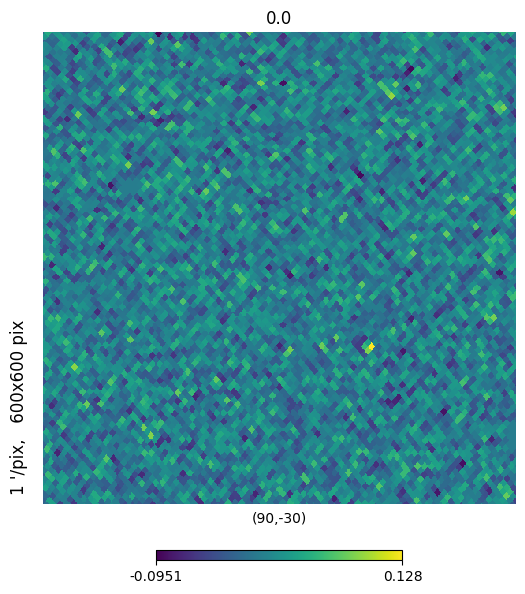

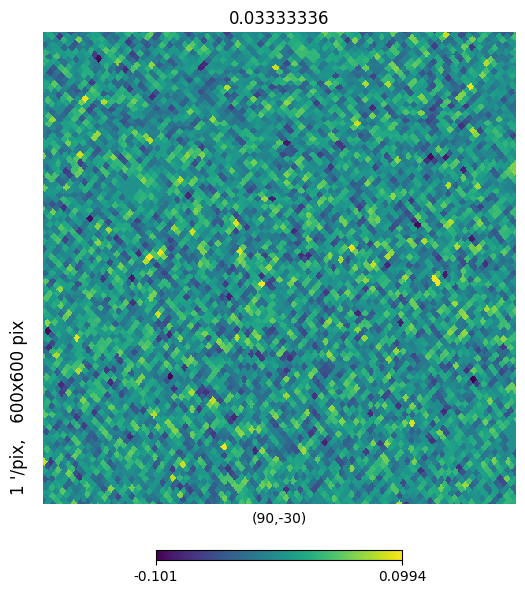

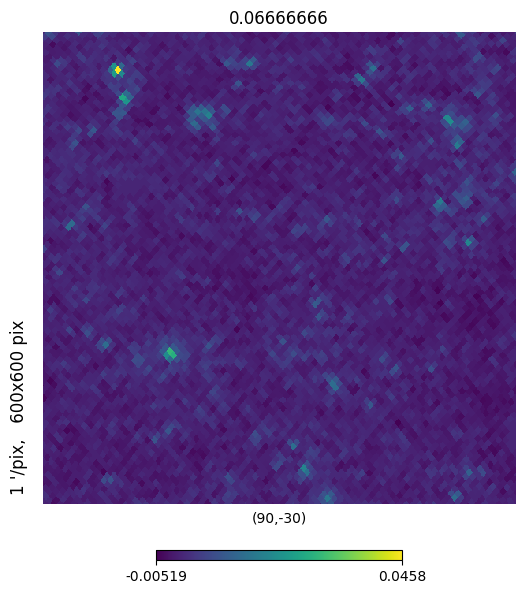

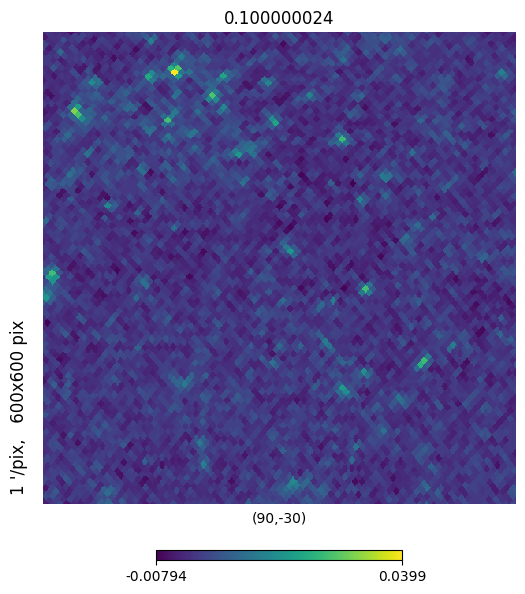

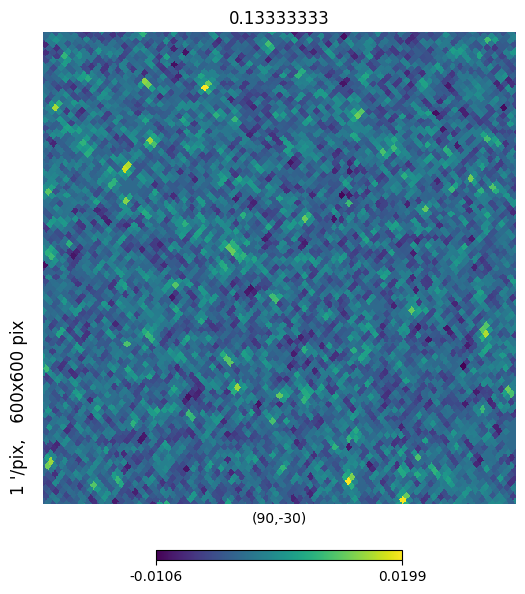

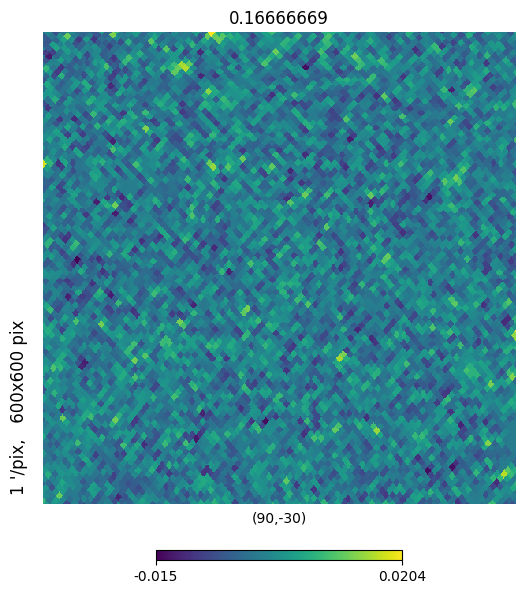

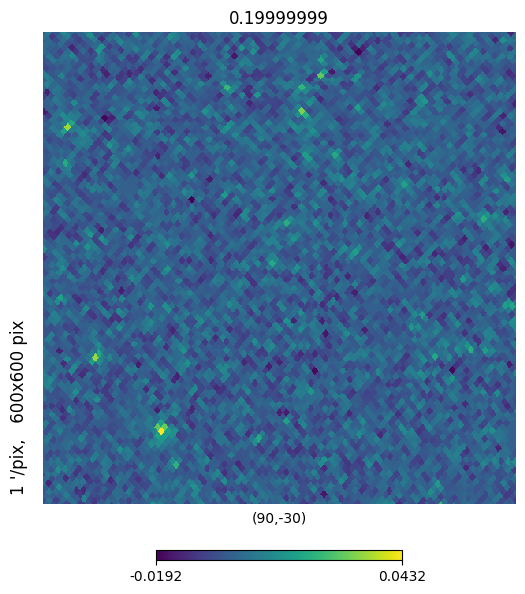

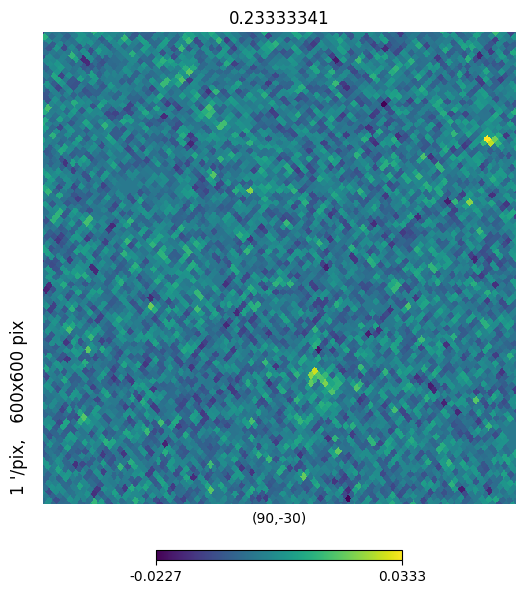

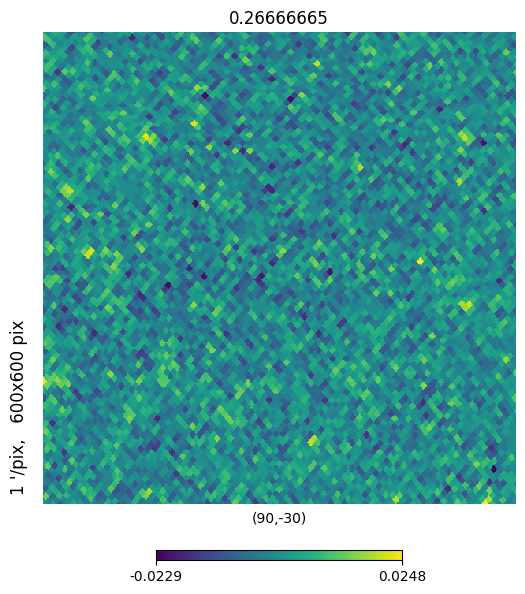

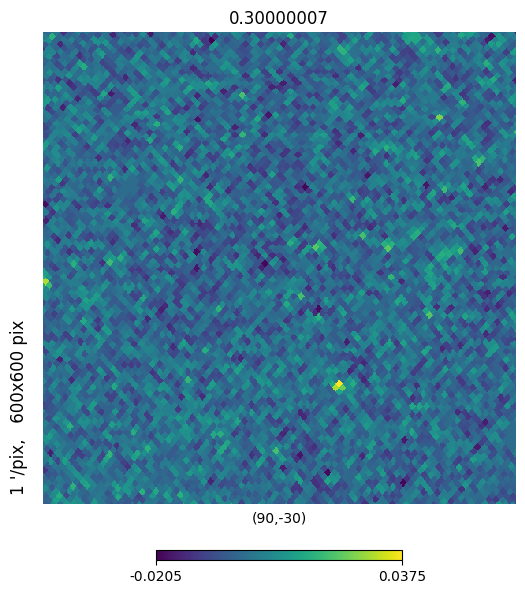

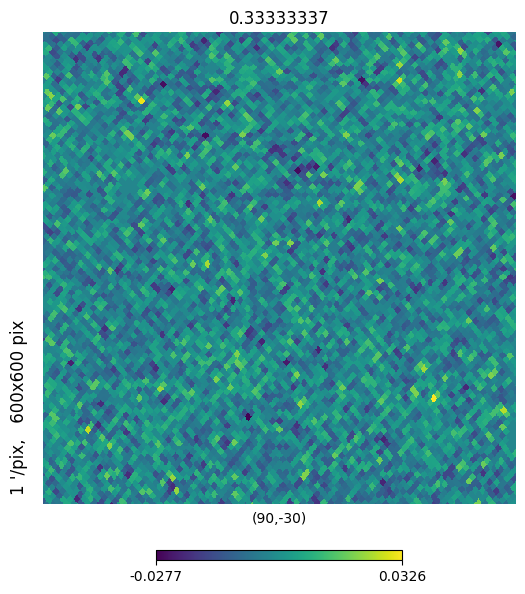

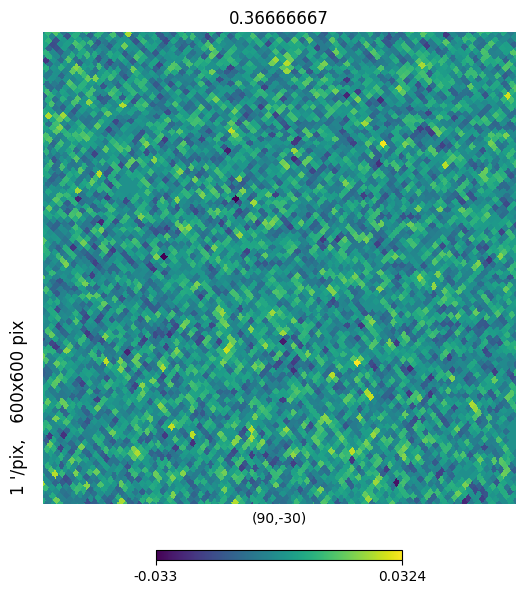

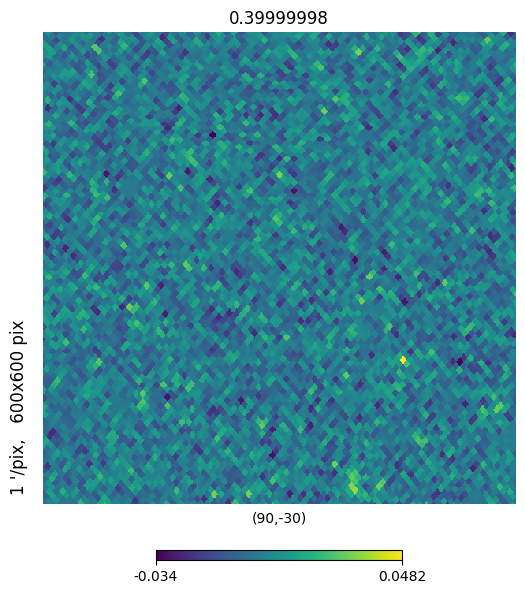

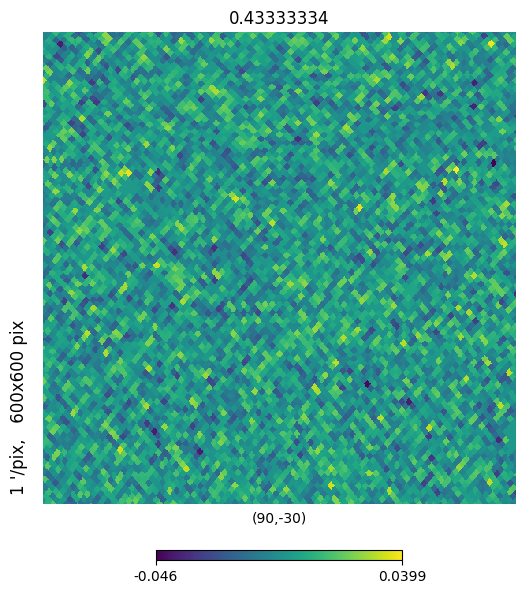

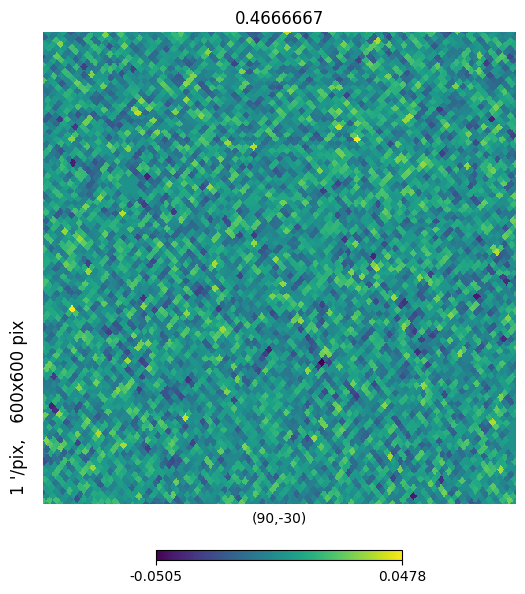

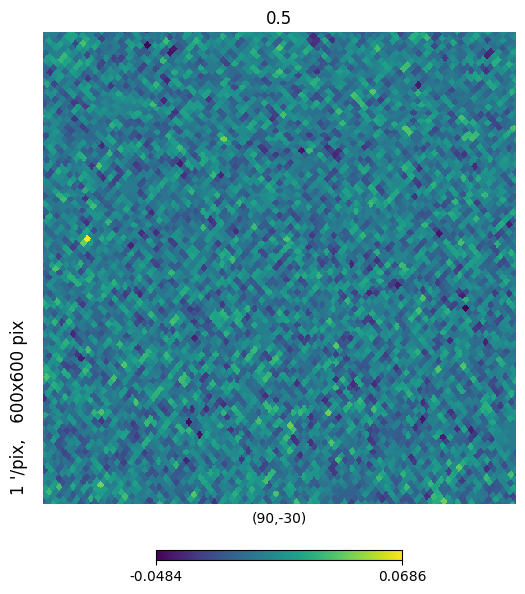

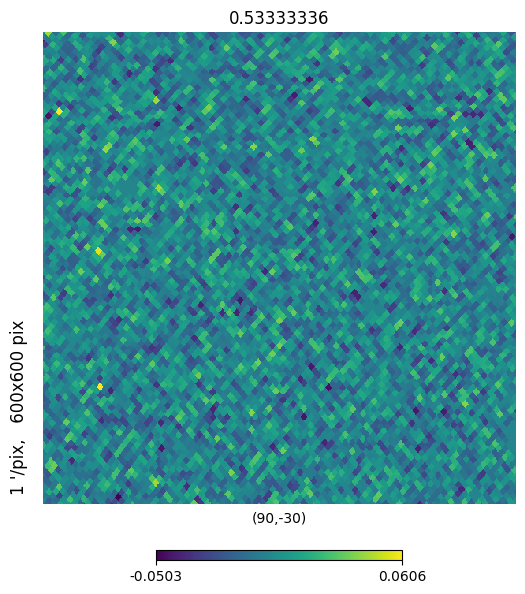

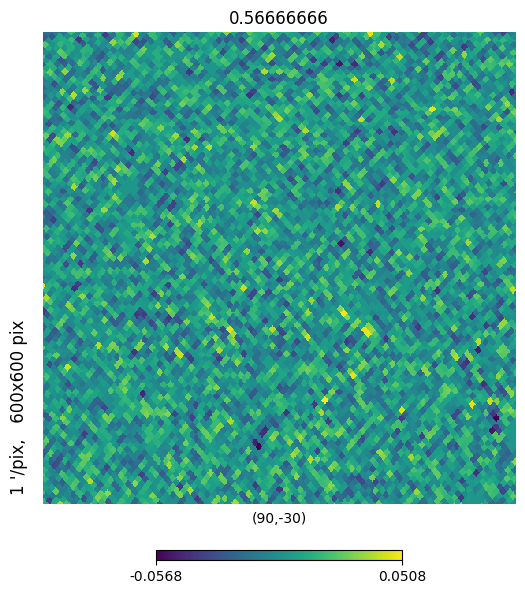

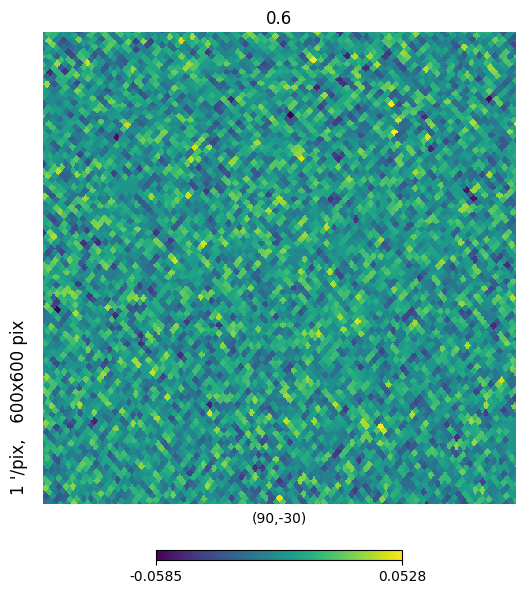

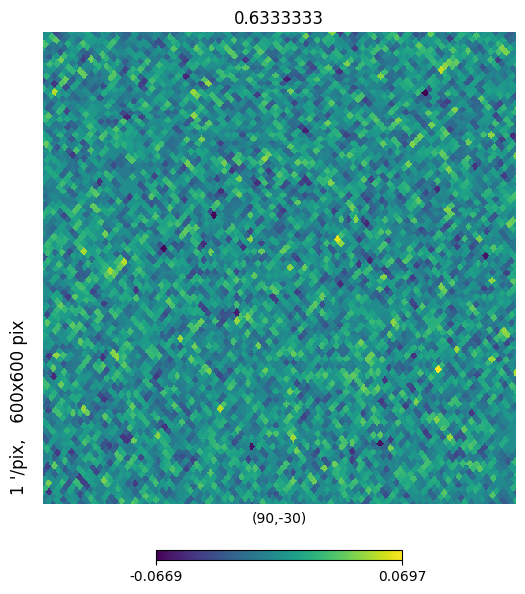

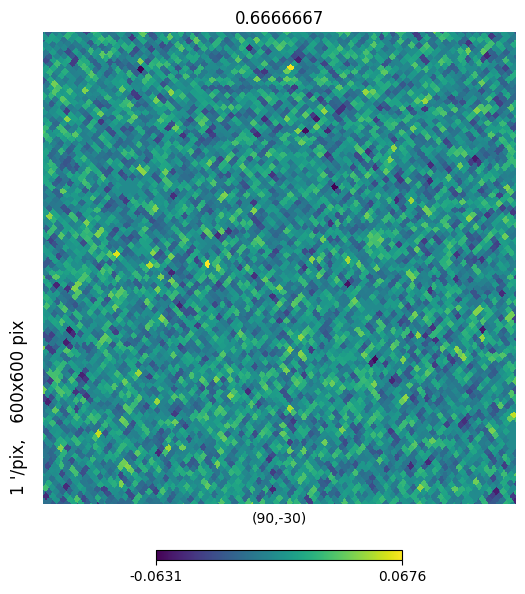

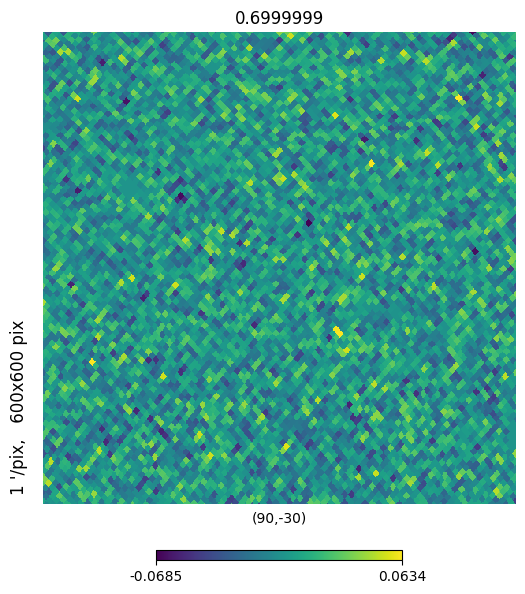

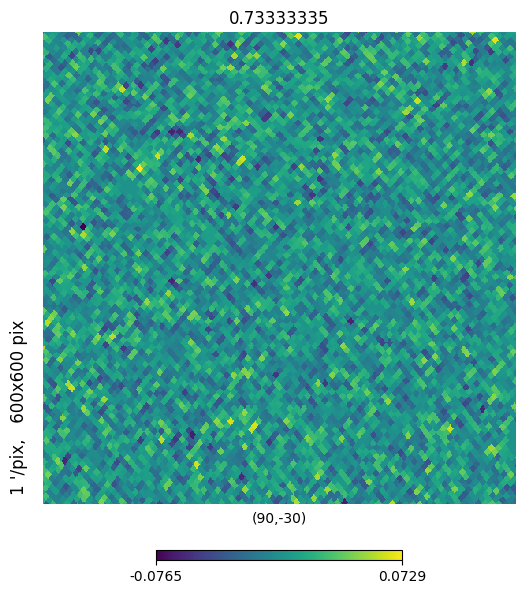

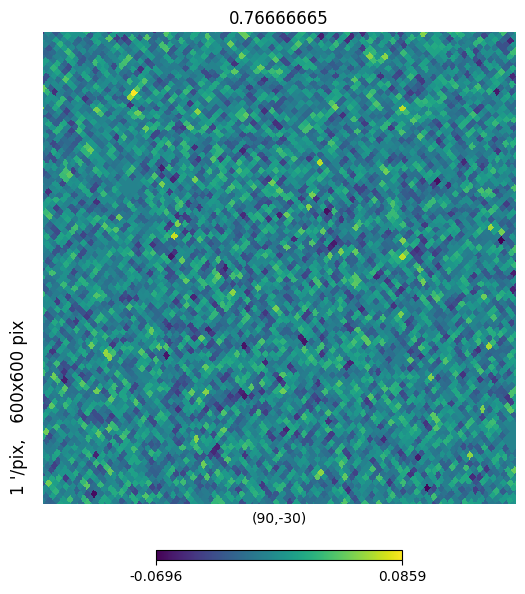

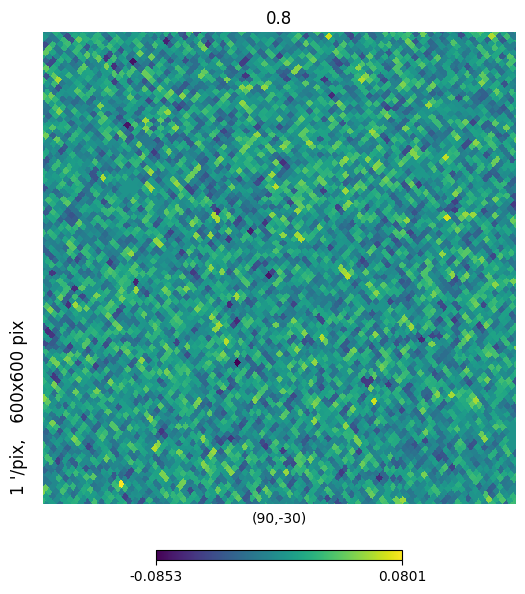

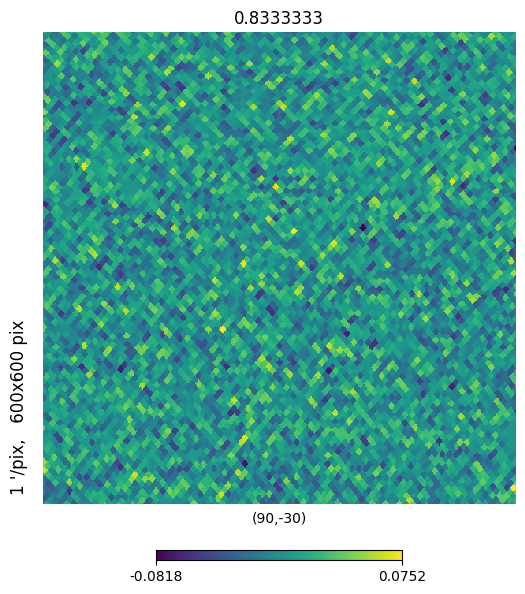

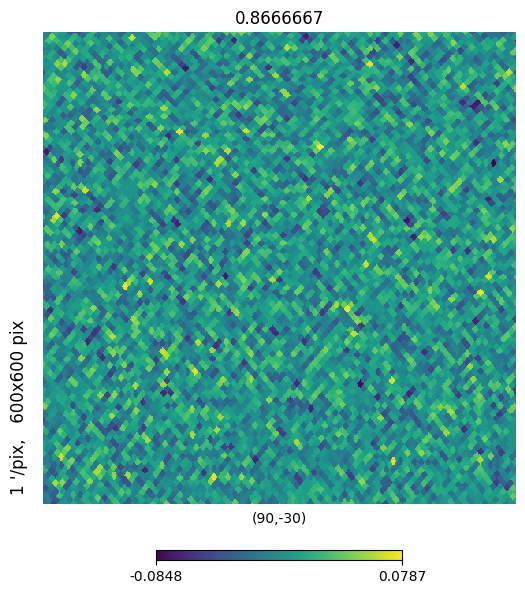

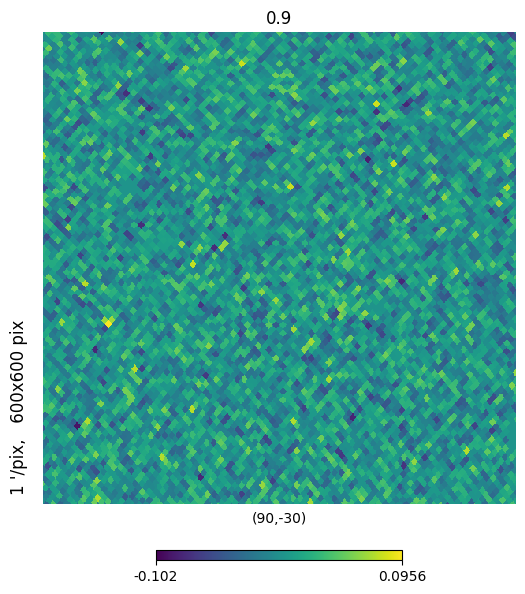

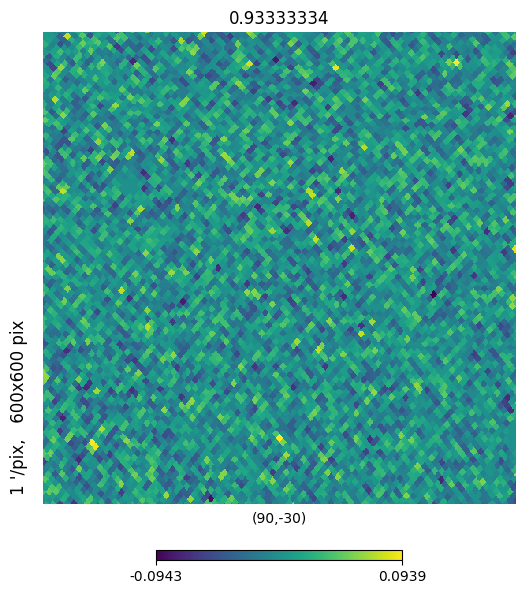

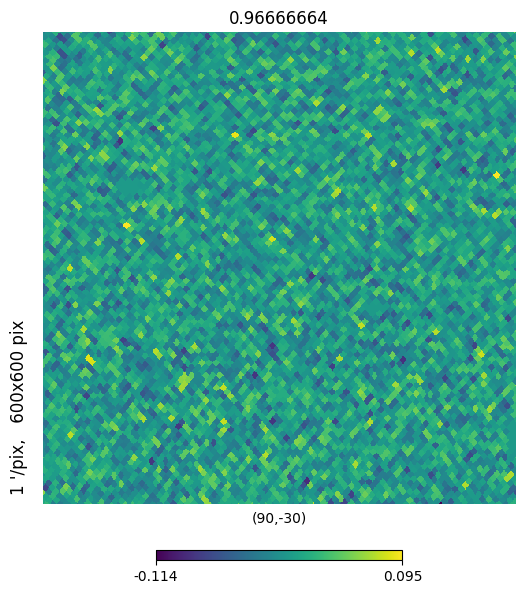

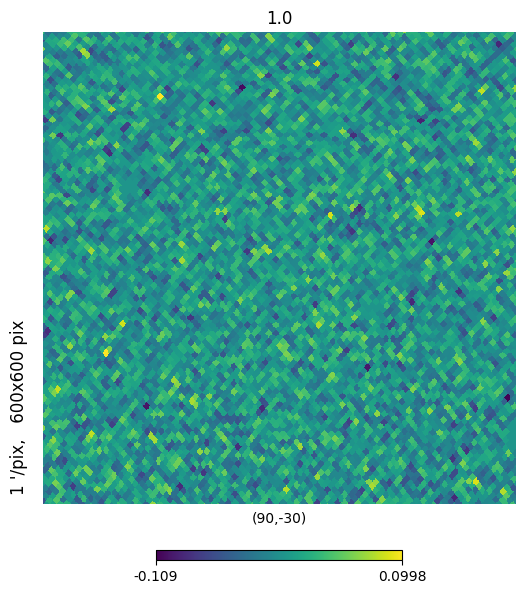

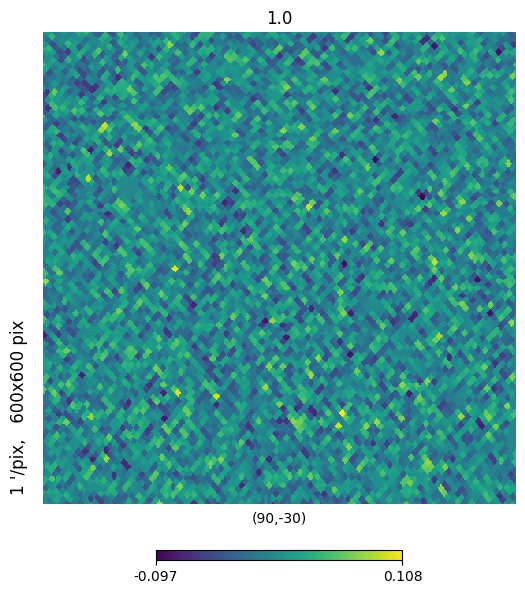

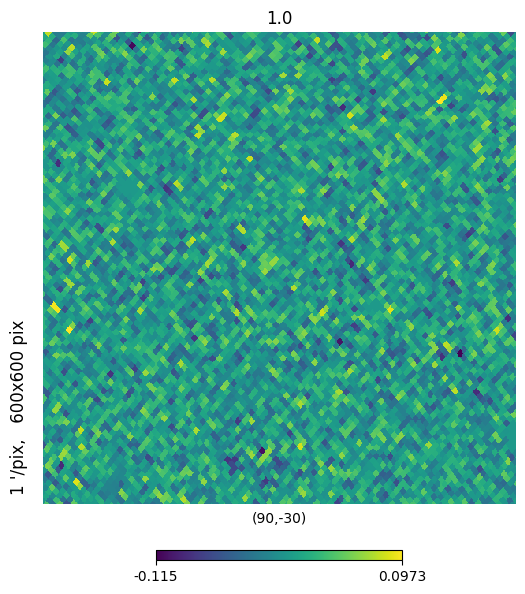

In [10]:
for i, (x, index) in enumerate(dset.take(noise_schedule_steps+3)):
    # print(i)
    hp_map = np.full(n_pix, hp.UNSEEN)
    hp_map[data_vec_pix] = x[0,:,0]
    
    current_noise = noise_scheduler(i)
    noise_scale.assign(current_noise)
    
    # hp.mollview(hp_map, nest=True, title=i)
    hp.gnomview(hp_map, nest=True, rot=(90, -30, 0), reso=reso, xsize=x_pix, ysize=y_pix, return_projected_map=False, no_plot=False, title=current_noise.numpy())
